# 📌 View

In [ ]:
gloView = 0.5

eqView = {
    ##"GPIX": {"weight": gloView, "gg_sheet_col": "C", "mcap":   717010000},
    ##"GPIQ": {"weight": gloView, "gg_sheet_col": "D", "mcap":   727230000},
    "JEPI": {"weight": gloView, "gg_sheet_col": "C", "mcap": 39240000000},
    "JEPQ": {"weight": gloView, "gg_sheet_col": "D", "mcap": 24720000000},
    "IDVO": {"weight": gloView, "gg_sheet_col": "E", "mcap":   233500000},
    "DVYE": {"weight": gloView, "gg_sheet_col": "F", "mcap":   751240000},
    "SGOV": {"weight": 1,       "gg_sheet_col": "G", "mcap": 46950000000}
}

dividend_symbols = eqView.keys()

##apiKey = ''
apiKey = ''

# 📌 Set Up

In [ ]:
config = {'api_key': apiKey}
client = TiingoClient(config)

In [ ]:
upperForeCap = 20
lowerForeCap = -20
lowerAdjForeCap = 0.10
moProp = 0.2
acProp = 0.2
boProp = 0.2
crProp = 0.2
skProp = 0.2
forcastDiverMuliplier = 1.7
expoStdLength = 32
crScalar = 30

# 📌 Scalar Calculation

In [ ]:
!pip install tiingo

In [ ]:
import warnings
import datetime
import math
import numpy as np
import pandas as pd
import pytz
import requests
from tiingo import TiingoClient
from scipy.stats import skew
from IPython.display import display

warnings.simplefilter("ignore", category=FutureWarning)

In [ ]:
BUSINESS_DAYS_IN_YEAR = 252
LATEST_N_DAYS = 2520

instruments_for_scalars = [
    # Global equity
    "VT", "SPY", "IWM", "EFA", "EEM",
    # Bonds / Fixed Income
    "AGG", "BNDX", "TIP", "HYG", "EMB",
    # Alternatives & commodities
    "GBTC", "DBC", "USO", "GLD",
    # REITs
    "VNQ", "VNQI",
    # Currency proxies (FX ETFs)
    "FXE", "FXY", "FXB", "FXA", "FXC",
    # Regional equity ETFs
    "EWU", "EWG", "FEZ",
    "EWJ", "EWH", "EWA", "INDA",
    # Rates / Yield-curve ETFs
    "BIL", "IEI", "IEF", "TLT"
]

In [ ]:
def add_adj_close(df):
    if "Close" in df.columns:
        df["Adj Close"] = df["Close"]
    if "Adj Close" in df.columns:
        return df["Adj Close"].squeeze()
    raise KeyError("No 'Adj Close' or 'Close' column available")

def compute_daily_price_vol(df):
    if "Adj Close" not in df.columns:
        add_adj_close(df)

    adj_close = df["Adj Close"].squeeze()
    returns = adj_close.pct_change().dropna()
    daily_exp_std_dev = returns.ewm(span=expoStdLength, adjust=False).std()
    ten_year_window = BUSINESS_DAYS_IN_YEAR * 10
    ten_year_vol = daily_exp_std_dev.rolling(ten_year_window,
                                             min_periods=1).mean()

    weighted_vol = 0.7 * daily_exp_std_dev + 0.3 * ten_year_vol
    daily_percent_vol = weighted_vol.iloc[-1]
    df["dailyPriceVol"] = daily_percent_vol * adj_close
    return df

def ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

def raw_momentum(close, dailyPriceVol, base_len, scalar=1):
    ema_fast = ema(close, base_len)
    ema_slow = ema(close, base_len * 4)
    scaledForc = (ema_fast - ema_slow) / dailyPriceVol * scalar
    return scaledForc, ema_fast, ema_slow

def momentum_scalar(close, daily_price_vol, base_len):
    diff_arr, shortEma, longEma = raw_momentum(close, daily_price_vol, base_len)
    avg_diff = diff_arr.tail(LATEST_N_DAYS).abs().mean()
    return avg_diff and 10 / avg_diff, shortEma, longEma

def scal_forecast_mo(fast_ema, slow_ema, volatility, scalar):
    risk_adjusted = (fast_ema - slow_ema) / volatility
    return risk_adjusted * scalar

def cap_forecast_ac(shift, scaled_forecast):
    return scaled_forecast - scaled_forecast.shift(shift)

def acceleration_scalar(acceleration_series):
    avg_abs = acceleration_series.abs().tail(LATEST_N_DAYS).mean()
    return avg_abs and 10 / avg_abs

def breakout_scalar(df, break_length):
    high_rolling = df.High.rolling(window=break_length).max()
    low_rolling = df.Low.rolling(window=break_length).min()
    mean_rolling = (high_rolling + low_rolling) / 2

    BoForc = (40 * (df.Close - mean_rolling)) / (high_rolling - low_rolling)
    smoothLength = max(1, int(break_length / 4))
    smoothForcBo = ema(BoForc, smoothLength)

    avg_abs = smoothForcBo.abs().tail(LATEST_N_DAYS).mean().item()
    return avg_abs and 10 / avg_abs

def raw_skew(returns, window):
    return -returns.rolling(window).apply(skew, raw=True)

def skew_scalar(returns, window):
    raw    = raw_skew(returns, window)
    smooth = raw.ewm(span=window * 4, adjust=False).mean()
    avg_abs = smooth.abs().tail(LATEST_N_DAYS).mean()
    return avg_abs and 10 / avg_abs

In [ ]:
results   = []
end_date  = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=30*365)

for symbol in instruments_for_scalars:
    try:
        df = client.get_dataframe(
            symbol,
            startDate=start_date.strftime("%Y-%m-%d"),
            endDate=  end_date.  strftime("%Y-%m-%d"),
            frequency='daily'
        )
    except Exception:
        results.append([symbol] + [0]*13)
        continue

    df = (
        df
        .reset_index()
        .rename(columns={
            'date':     'Date',
            'open':     'Open',
            'high':     'High',
            'low':      'Low',
            'close':    'Close',
            'adjClose': 'Adj Close'
        })
        .dropna()
        .sort_values('Date')
    )

    if df.empty:
        results.append([symbol] + [0]*13)
        continue

    add_adj_close(df)
    df = compute_daily_price_vol(df)
    close   = df["Adj Close"].squeeze()
    returns = close.pct_change().dropna()

    rapidMoScalar, _, _      = momentum_scalar(close, df.dailyPriceVol, 8)
    fastMoScalar, f_fast, f_slow = momentum_scalar(close, df.dailyPriceVol, 16)
    medMoScalar, m_fast, m_slow  = momentum_scalar(close, df.dailyPriceVol, 32)
    slowMoScalar, s_fast, s_slow = momentum_scalar(close, df.dailyPriceVol, 64)

    scaledF = scal_forecast_mo(f_fast, f_slow, df["dailyPriceVol"], fastMoScalar)
    fastAc = acceleration_scalar(cap_forecast_ac(16, scaledF))

    scaledM = scal_forecast_mo(m_fast, m_slow, df["dailyPriceVol"], medMoScalar)
    medAc  = acceleration_scalar(cap_forecast_ac(32, scaledM))

    scaledS  = scal_forecast_mo(s_fast, s_slow, df["dailyPriceVol"], slowMoScalar)
    slowAc   = acceleration_scalar(cap_forecast_ac(64, scaledS))

    br20 = breakout_scalar(df, 20)
    br40 = breakout_scalar(df, 40)
    br80 = breakout_scalar(df, 80)

    sk60  = skew_scalar(returns, 60)
    sk120 = skew_scalar(returns, 120)
    sk240 = skew_scalar(returns, 240)

    results.append([
        symbol,
        rapidMoScalar, fastMoScalar, medMoScalar, slowMoScalar,
        fastAc, medAc, slowAc,
        br20, br40, br80,
        sk60, sk120, sk240
    ])

cols = [
    "Symbol","rapidMo","fastMo","mediumMo","slowMo",
    "acFast","acMedium","acSlow",
    "bo20","bo40","bo80",
    "skew60","skew120","skew240"
]
df_res      = pd.DataFrame(results, columns=cols)
scalars_avg = df_res[cols[1:]].mean()
averages    = scalars_avg.to_dict()

# 📌 Expected Dividend

In [ ]:
client = TiingoClient({"api_key": apiKey})

end_dt   = datetime.date.today()
start_dt = end_dt - datetime.timedelta(days=365)

for sym in eqView:
    df = client.get_dataframe(
        sym,
        startDate=start_dt.isoformat(),
        endDate=end_dt.isoformat(),
        frequency="daily"
    )
    if not df.empty and "divCash" in df and "adjClose" in df:
        total_divs = df["divCash"].fillna(0).sum()
        last_price = df["adjClose"].iloc[-1]
        eqView[sym]["expectedDiv"] = total_divs / last_price
    else:
        eqView[sym]["expectedDiv"] = 0.0

dividend_results = [
    [sym, eqView[sym]["expectedDiv"]]
    for sym in eqView
]
df_dividends = (
    pd.DataFrame(dividend_results, columns=["Symbol", "expectedDiv"])
      .set_index("Symbol")
)

print("\n=== Each Ticker's Tiingo‐Fetched expectedDiv (%) ===")
print(df_dividends)


=== Each Ticker's Tiingo‐Fetched expectedDiv (%) ===
        expectedDiv
Symbol             
JEPI       0.080738
JEPQ       0.114933
IDVO       0.057945
DVYE       0.113498
SGOV       0.047049


# 📌 Forecast Calculation

In [ ]:
expected_div_map = dict(zip(df_dividends.index, df_dividends["expectedDiv"]))

In [ ]:
def compute_instRisk_dailyPriceVol(symbol, expoStdLength=expoStdLength):
    df = client.get_dataframe(
        symbol,
        startDate=(datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime("%Y-%m-%d"),
        endDate=  datetime.datetime.now().strftime("%Y-%m-%d"),
        frequency='daily'
    )
    if df.empty:
        return None, None, None

    df = (
        df
        .reset_index()
        .rename(columns={
            'date':     'Date',
            'open':     'Open',
            'high':     'High',
            'low':      'Low',
            'close':    'Close',
            'adjClose': 'Adj Close'
        })
        .dropna()
        .sort_values('Date')
    )

    close = add_adj_close(df)
    returns = close.pct_change().dropna()
    daily_exp_std_dev = returns.ewm(span=expoStdLength, adjust=False).std()

    ten_year_window = BUSINESS_DAYS_IN_YEAR * 10
    ten_year_vol = daily_exp_std_dev.rolling(ten_year_window, min_periods=1).mean()

    weighted_vol = 0.7 * daily_exp_std_dev + 0.3 * ten_year_vol
    dailyPercentVol = weighted_vol.iloc[-1]
    last_close = close.iloc[-1]
    dailyPriceVol = dailyPercentVol * last_close
    instRisk = round(dailyPercentVol * 16, 6)
    return instRisk, dailyPriceVol, df

def momentum_forecast(df, base_len, scalar, dailyPriceVol):
    raw_scaledForc, _, _ = raw_momentum(df, dailyPriceVol, base_len, scalar)
    return np.clip(raw_scaledForc.iloc[-1], lowerForeCap, upperForeCap), raw_scaledForc

def acceleration_forecast(period, raw_scaledForc_series, forecastAcScalar):
    forcAc = raw_scaledForc_series.iloc[-1] - raw_scaledForc_series.iloc[-period]
    scaledForcAc = forcAc * forecastAcScalar
    return np.clip(scaledForcAc, lowerForeCap, upperForeCap)

def breakout_forecast(df, break_length, ForecastScalar):
    close_val = df.Close.iloc[-1]
    high = df.High.tail(break_length).max()
    low  = df.Low.tail(break_length).min()
    hl_range = high - low
    if hl_range == 0:
        return 0.0

    mean_val    = (high + low) / 2
    BoForc      = (40 * (close_val - mean_val)) / hl_range
    scaledForc  = BoForc * ForecastScalar

    return np.clip(scaledForc, lowerForeCap, upperForeCap)

def carry_forecast(df, expectedDiv, smoothLength, instRisk, ForecastScalar):
    if instRisk == 0:
        return 0.0

    cr_forc = pd.Series((expectedDiv * ForecastScalar) / instRisk)
    scaledForcCr = ema(cr_forc, smoothLength).iloc[-1]

    return np.clip(scaledForcCr, lowerForeCap, upperForeCap)

def raw_skew(series, window):
    return -series.rolling(window).apply(skew, raw=True)

def skew_forecast(returns, window, scalar):
    raw   = raw_skew(returns, window)
    smooth = raw.ewm(span=window*4, adjust=False).mean()
    latest = smooth.iloc[-1] * scalar
    return np.clip(latest, lowerForeCap, upperForeCap)

def combine_forecasts(cappedMo, cappedAc, cappedBo, cappedCr, cappedSk):
    combForc = (
        cappedMo * moProp +
        cappedAc * acProp +
        cappedBo * boProp +
        cappedCr * crProp +
        cappedSk * skProp
    )
    scalCombForc = combForc * forcastDiverMuliplier
    cappedCombForc = np.clip(scalCombForc, lowerForeCap, upperForeCap)
    return cappedCombForc / 10

In [ ]:
final_results = []
for symbol in expected_div_map:
    instRisk, dailyPriceVol, df_data = compute_instRisk_dailyPriceVol(symbol, expoStdLength)
    if df_data is None:
        final_results.append([symbol, None, None]); continue

    close   = add_adj_close(df_data)
    returns = close.pct_change().dropna()
    expectedDiv = expected_div_map[symbol]

    cappedForcR, _ = momentum_forecast(close, 8, scalars_avg.rapidMo, dailyPriceVol)
    cappedForcF, rawScaledForcF = momentum_forecast(close, 16, scalars_avg.fastMo, dailyPriceVol)
    cappedForcM, rawScaledForcM = momentum_forecast(close, 32, scalars_avg.mediumMo, dailyPriceVol)
    cappedForcS, rawScaledForcS = momentum_forecast(close, 64, scalars_avg.slowMo, dailyPriceVol)
    cappedForcMo = np.mean([cappedForcR, cappedForcF, cappedForcM, cappedForcS])

    cappedForcFAc = acceleration_forecast(16, rawScaledForcF, scalars_avg.acFast)
    cappedForcMAc = acceleration_forecast(32, rawScaledForcM, scalars_avg.acMedium)
    cappedForcSAc = acceleration_forecast(64, rawScaledForcS, scalars_avg.acSlow)
    cappedForcAc = np.mean([cappedForcFAc, cappedForcMAc, cappedForcSAc])

    cappedForcBo20 = breakout_forecast(df_data, 20, scalars_avg.bo20)
    cappedForcBo40 = breakout_forecast(df_data, 40, scalars_avg.bo40)
    cappedForcBo80 = breakout_forecast(df_data, 80, scalars_avg.bo80)
    cappedForcBo = np.mean([cappedForcBo20, cappedForcBo40, cappedForcBo80])

    cappedForcCr20 = carry_forecast(df_data, expectedDiv, 20, instRisk, crScalar)
    cappedForcCr60 = carry_forecast(df_data, expectedDiv, 60, instRisk, crScalar)
    cappedForcCr120 = carry_forecast(df_data, expectedDiv, 120, instRisk, crScalar)
    cappedForcCr = np.mean([cappedForcCr20, cappedForcCr60, cappedForcCr120])

    cappedSk60  = skew_forecast(returns, 60 , scalars_avg.skew60)
    cappedSk120 = skew_forecast(returns, 120, scalars_avg.skew120)
    cappedSk240 = skew_forecast(returns, 240, scalars_avg.skew240)
    cappedForcSk = np.mean([cappedSk60, cappedSk120, cappedSk240])

    rawCombForc = combine_forecasts(cappedForcMo, cappedForcAc,cappedForcBo, cappedForcCr, cappedForcSk)
    adjCombForc = np.clip(rawCombForc, lowerAdjForeCap, upperForeCap)

    expectedExRet = adjCombForc * instRisk
    omega_i       = instRisk ** 2

    final_results.append([symbol, cappedForcMo, cappedForcAc, cappedForcBo, cappedForcCr, cappedForcSk, adjCombForc, instRisk, expectedExRet, omega_i])

In [ ]:
df_final = pd.DataFrame(
    final_results,
    columns=["Symbol", "cappedForcMo", "cappedForcAc", "cappedForcBo", "cappedForcCr", "cappedForcSk", "adjCombForc", "instRisk", "expectedExRet", "omega_i"],
).set_index("Symbol")

# 📌 Scalar & Forecast

In [ ]:
scalars_avg

,0
rapidMo,8.419426
fastMo,5.936618
mediumMo,4.181477
slowMo,2.994910
acFast,1.435908
acMedium,1.431284
acSlow,1.420803
bo20,1.011263
bo40,1.039123
bo80,1.036000


In [ ]:
df_final

,cappedForcMo,cappedForcAc,cappedForcBo,cappedForcCr,cappedForcSk,adjCombForc,instRisk,expectedExRet,omega_i
Symbol,,,,,,,,,
JEPI,-5.438826,-2.598665,9.964936,12.275251,17.106058,1.064498,0.197319,0.210046,0.038935
JEPQ,-5.420370,-2.816357,9.809962,12.619320,11.924761,0.887989,0.273231,0.242626,0.074655
IDVO,5.283139,4.444706,14.137254,7.525164,7.297758,1.315393,0.231006,0.303864,0.053364
DVYE,2.488101,5.127402,16.084299,14.655776,20.000000,1.984090,0.232327,0.460958,0.053976
SGOV,-1.043068,-0.548902,-4.375269,20.000000,20.000000,1.157114,0.011163,0.012917,0.000125


# 📌 Data for Black-Litterman

In [ ]:
end_dt   = datetime.datetime.now()
start_dt = end_dt - datetime.timedelta(days=365*100)
tz       = pytz.timezone("America/New_York")
start_dt = tz.localize(start_dt)
end_dt   = tz.localize(end_dt)

start_str = start_dt.strftime("%Y-%m-%d")
end_str   = end_dt.strftime("%Y-%m-%d")

In [ ]:
prices = client.get_dataframe(
    dividend_symbols,
    startDate=start_str,
    endDate=end_str,
    frequency='daily',
    metric_name='adjClose'
)

In [ ]:
market_prices = client.get_dataframe(
    'SPY',
    startDate=start_str,
    endDate=end_str,
    frequency='daily',
    metric_name='adjClose'
)

In [ ]:
mcaps = { symbol: props["mcap"] for symbol, props in eqView.items() }
print(mcaps)

{'JEPI': 39240000000, 'JEPQ': 24720000000, 'IDVO': 233500000, 'DVYE': 751240000, 'SGOV': 46950000000}


# 📌 Black-Litterman Calculation

## Library

In [ ]:
!pip install PyPortfolioOpt

In [ ]:
import matplotlib.pyplot as plt

## Instrument

In [ ]:
df_final = pd.DataFrame(
    final_results,
    columns=[
        "Symbol", "cappedForcMo", "cappedForcAc", "cappedForcBo",
        "cappedForcCr", "cappedForcSk",
        "adjCombForc",
        "instRisk",
        "expExRet",
        "Omega"
    ]
).set_index("Symbol")
df_final

,cappedForcMo,cappedForcAc,cappedForcBo,cappedForcCr,cappedForcSk,adjCombForc,instRisk,expExRet,Omega
Symbol,,,,,,,,,
JEPI,-5.438826,-2.598665,9.964936,12.275251,17.106058,1.064498,0.197319,0.210046,0.038935
JEPQ,-5.420370,-2.816357,9.809962,12.619320,11.924761,0.887989,0.273231,0.242626,0.074655
IDVO,5.283139,4.444706,14.137254,7.525164,7.297758,1.315393,0.231006,0.303864,0.053364
DVYE,2.488101,5.127402,16.084299,14.655776,20.000000,1.984090,0.232327,0.460958,0.053976
SGOV,-1.043068,-0.548902,-4.375269,20.000000,20.000000,1.157114,0.011163,0.012917,0.000125


In [ ]:
weights_view = {sym: eqView[sym]["weight"] for sym in df_final.index}

viewdict = {
    sym: round(df_final.loc[sym, "expExRet"] * weights_view[sym], 5)
    for sym in df_final.index
}
viewdict["SGOV"] = df_dividends.loc["SGOV", "expectedDiv"]
viewdict

{'JEPI': np.float64(0.10502),
 'JEPQ': np.float64(0.12131),
 'IDVO': np.float64(0.15193),
 'DVYE': np.float64(0.23048),
 'SGOV': np.float64(0.047048546974522286)}

In [ ]:
omega_diag = df_final.loc[viewdict.keys(), "Omega"]
Omega = np.diag(omega_diag.values)
Omega

array([[0.03893479, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.07465518, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.05336377, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.05397583, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00012461]])

## Constructing the prior

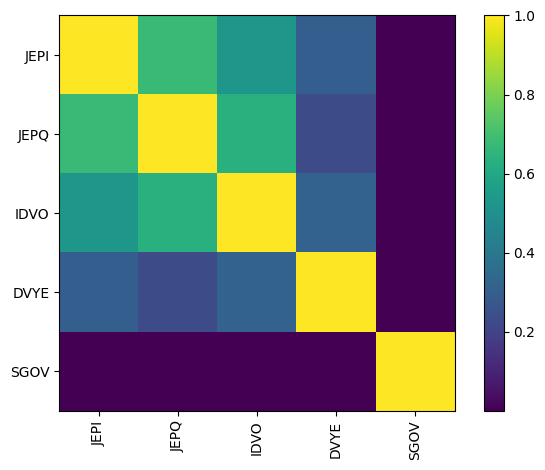

In [ ]:
from pypfopt import BlackLittermanModel, black_litterman, plotting, risk_models

S      = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta  = black_litterman.market_implied_risk_aversion(market_prices)
pi     = black_litterman.market_implied_prior_returns(mcaps, delta, S)
plotting.plot_covariance(S, plot_correlation=True);

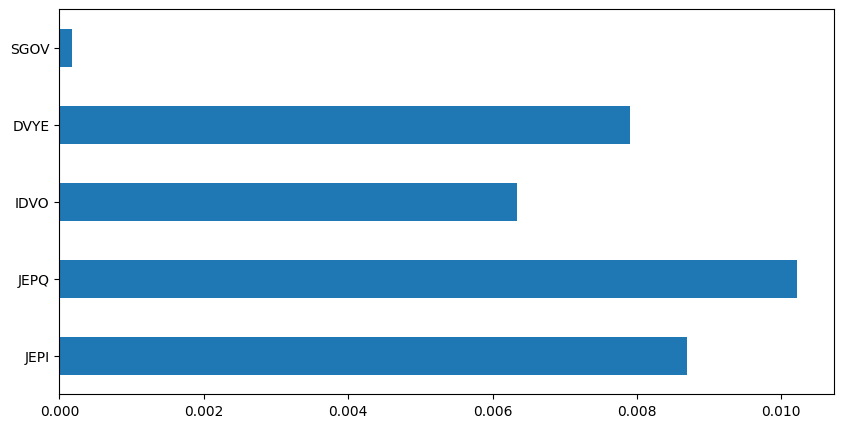

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior.plot.barh(figsize=(10,5));

## Confidences

In [ ]:
bl = BlackLittermanModel(
        S,
        pi               = pi,
        absolute_views   = viewdict,
        omega            = Omega
)

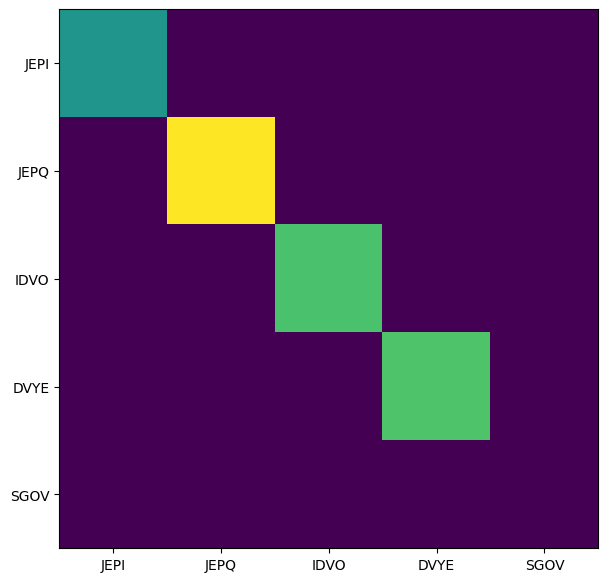

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [ ]:
np.diag(bl.omega)

array([0.03893479, 0.07465518, 0.05336377, 0.05397583, 0.00012461])

In [ ]:
ret_bl = bl.bl_returns()
ret_bl

,0
JEPI,0.010744
JEPQ,0.012607
IDVO,0.008641
DVYE,0.016016
SGOV,0.002345


In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
JEPI,0.008692,0.010744,0.105020
JEPQ,0.010223,0.012607,0.121310
IDVO,0.006342,0.008641,0.151930
DVYE,0.007899,0.016016,0.230480
SGOV,0.000170,0.002345,0.047049


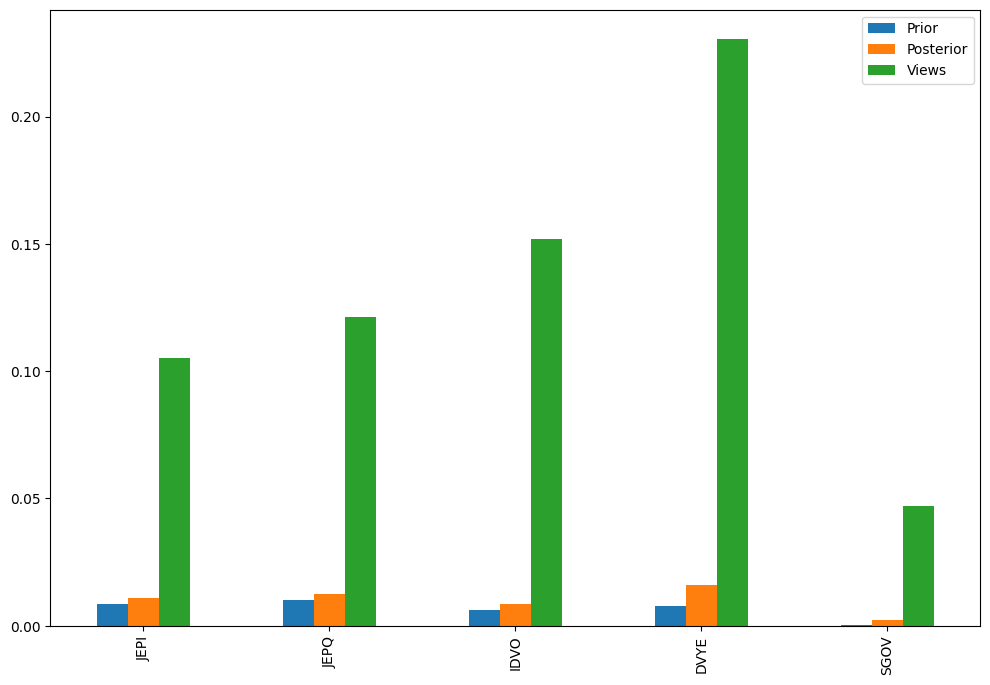

In [ ]:
rets_df.plot.bar(figsize=(12,8));

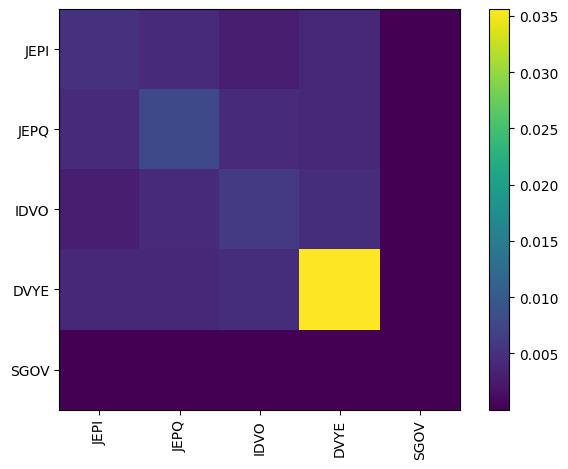

In [ ]:
S_bl   = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

## Final Allocation

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('JEPI', 0.21514),
             ('JEPQ', 0.25222),
             ('IDVO', 0.172),
             ('DVYE', 0.31283),
             ('SGOV', 0.04781)])

Expected annual return: 1.2%
Annual volatility: 8.4%
Sharpe Ratio: 0.14


/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(np.float64(0.012099937185580879),
 np.float64(0.08435844142986142),
 np.float64(0.14343481198193062))

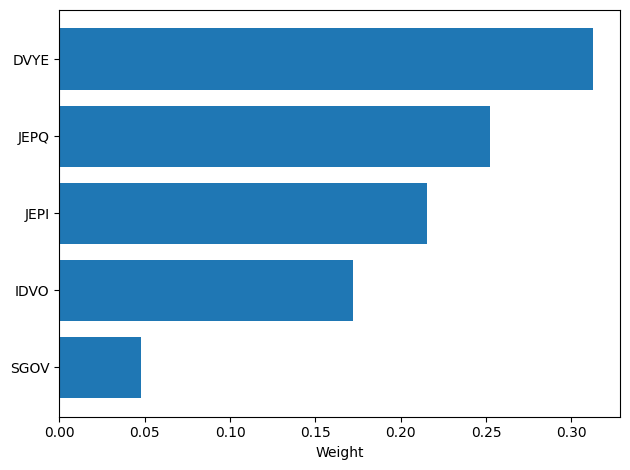

In [ ]:
from pypfopt.plotting import plot_weights

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

## Update Google Sheet

In [ ]:
from google.colab import auth, files

auth.authenticate_user()
import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

import datetime

import pytz

bangkok_tz = pytz.timezone("Asia/Bangkok")
now = datetime.datetime.now(bangkok_tz).strftime("%y-%m-%d %H:%M")

In [ ]:
scaled_weights = {
    sym: weights.get(sym,0.0) * eqView[sym]["weight"]
    for sym in weights}

In [ ]:
sheet = gc.open_by_key("1IhQ5wwb6XTO1lUYqFzFTqsKBSvBfmGM3bH5Cje05LGg").worksheet("Allocation")

for dividend, v in eqView.items():
    if dividend != "SGOV":
        sheet.update_acell(f"{v['gg_sheet_col']}9", str(scaled_weights[dividend]))

    sheet.update_acell(f"{v['gg_sheet_col']}10", str(df_dividends.loc[dividend].expectedDiv))

sheet.update_acell("H5", now)

{'spreadsheetId': '1IhQ5wwb6XTO1lUYqFzFTqsKBSvBfmGM3bH5Cje05LGg',
 'updatedRange': 'Allocation!H5',
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

In [ ]:
sheet = gc.open_by_key("1IhQ5wwb6XTO1lUYqFzFTqsKBSvBfmGM3bH5Cje05LGg").worksheet("Staunch")

for dividend, v in eqView.items():
    sheet.update_acell(f"{v['gg_sheet_col']}12", str(df_final.loc[dividend].adjCombForc))
    sheet.update_acell(f"{v['gg_sheet_col']}13", str(df_final.loc[dividend].instRisk))
    sheet.update_acell(f"{v['gg_sheet_col']}21", str(df_dividends.loc[dividend].expectedDiv))

sheet.update_acell("A7", now)

{'spreadsheetId': '1IhQ5wwb6XTO1lUYqFzFTqsKBSvBfmGM3bH5Cje05LGg',
 'updatedRange': 'Staunch!A7',
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

In [ ]:
def covariance_to_correlation(cov_matrix):
    stddev = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix / np.outer(stddev, stddev)
    return pd.DataFrame(corr_matrix, index=cov_matrix.index, columns=cov_matrix.columns)

correlation_matrix = covariance_to_correlation(S)
sheet.update_acell("C29", correlation_matrix.iloc[0, 1])
sheet.update_acell("D29", correlation_matrix.iloc[0, 2])
sheet.update_acell("E29", correlation_matrix.iloc[0, 3])
sheet.update_acell("D30", correlation_matrix.iloc[1, 2])
sheet.update_acell("E30", correlation_matrix.iloc[1, 3])
sheet.update_acell("E31", correlation_matrix.iloc[2, 3])

{'spreadsheetId': '1IhQ5wwb6XTO1lUYqFzFTqsKBSvBfmGM3bH5Cje05LGg',
 'updatedRange': 'Staunch!E31',
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}